In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import handytools.visualizer as vis
import handytools.navigator as nav
import spectools.models.models as mdl
from IPython.display import clear_output
from spectools.models.calc import get_RF, get_RF_resnet
from spectools.stimulus.wyeth import get_stimulus
from spectools.responses import get_response_wrapper, get_drr_wrapper
from spectools.metrics.metrics import responsive, get_prs
from spectools.models.models import AN_layer, VGG16b_layer, ResNet18_layer

In [3]:
def get_TK_stimulus(normalization):
    image_arrays = []
    for i in range(393): # 225 to 393 is texture
        image_array = nav.npload(nav.homepath, "data", "stimulus_TK", f"idx={i}_pxl=227.npy")
        image_array = np.expand_dims(image_array, (0,1))
        image_array = np.tile(image_array, (1,3,1,1))
        image_array = normalization(image_array)
        image_arrays.append(image_array)
    image_arrays = np.vstack(image_arrays)
    return torch.from_numpy(image_arrays)

def get_50000_images(idxs=range(50000)):
    path = "/dataloc/images_npy/"
    arrays = [np.expand_dims(nav.npload(path, str(i)+".npy"), 0) for i in idxs]
    return torch.from_numpy(np.vstack(arrays))

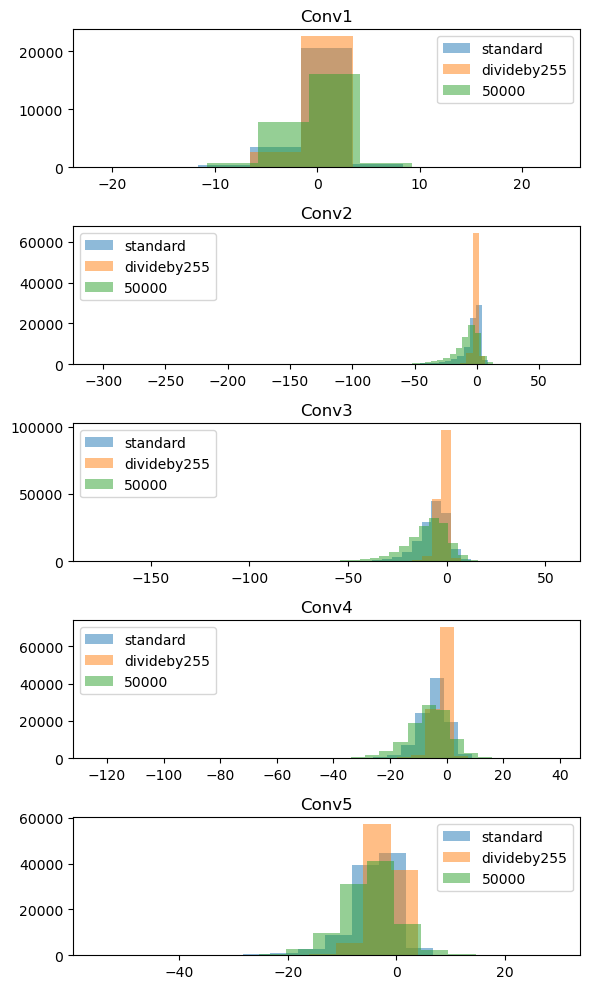

In [7]:
# params
ldic = AN_layer
mtype = "AN"
hkeys = list(ldic.keys())

# normalization
normdic = {"standard": lambda x:(x-51.)/(100.-51.),
           "divideby255": lambda x: x/255.,
           }
respdic = {}

# stimulus
for normname, norm in normdic.items():
    stim = get_TK_stimulus(normalization=norm)
    fname1 = lambda hkey: f"hkey={hkey}_TK_norm={normname}.npy"
    Rs = get_response_wrapper(hkeys, stim, fname1, mtype=mtype, device="cuda:0")
    respdic[normname] = Rs
clear_output()

# natural stimulus
seed = 42
np.random.seed(seed)
stim = get_50000_images(np.random.randint(0, 50000, 400))
fname1 = lambda hkey: f"hkey={hkey}_50000_seed={seed}.npy"
Rs = get_response_wrapper(hkeys, stim, fname1, mtype=mtype, device="cuda:0")
respdic["50000"] = Rs

# plot
n = len(hkeys)
fig = plt.figure(figsize=(3*2, n*2))
for k in range(n):
    ax = fig.add_subplot(n, 1, k+1)
    hkey = hkeys[k]
    for normname in respdic.keys():
        res = respdic[normname][hkey].flatten()
        minn, maxx = min(res), max(res)
        ax.hist(respdic[normname][hkey].flatten(), label=normname, alpha=0.5, bins=np.arange(minn, maxx+1, 5))
    plt.legend()
    ax.set_title(ldic[hkey])
plt.tight_layout(); plt.show()
